## Run `braai`

In [1]:
from IPython.core.display import display, HTML
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.utils import normalize as tf_norm
import json
from bson.json_util import loads, dumps
import numpy as np
import pandas as pd
import gzip
import os
import io
from astropy.io import fits

import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
def load_model_helper(path, model_base_name):
    """
        Build keras model using json-file with architecture and hdf5-file with weights
    """
    with open(os.path.join(path, f'{model_base_name}.architecture.json'), 'r') as json_file:
        loaded_model_json = json_file.read()
    m = model_from_json(loaded_model_json)
    m.load_weights(os.path.join(path, f'{model_base_name}.weights.h5'))

    return m

In [3]:
def make_triplet(alert, normalize: bool = False, old_norm: bool = False, to_tpu: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    if not old_norm:
                        cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])
                    else:
                        # model <= d6_m7
                        cutout_dict[cutout] = tf_norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            # print(f'Shape of {candid}/{cutout}: {shape}, padding to (63, 63)')
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']
    
    if to_tpu:
        # Edge TPUs require additional processing
        triplet = np.rint(triplet * 128 + 128).astype(np.uint8).flatten()
    
    return triplet

In [4]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=100)
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    plt.show()

#### Load the model and run classifier

In [5]:
model = load_model_helper(path='../models', model_base_name='d6_m7')

An alert from a SN detected in $i$-band

0.4333333373069763


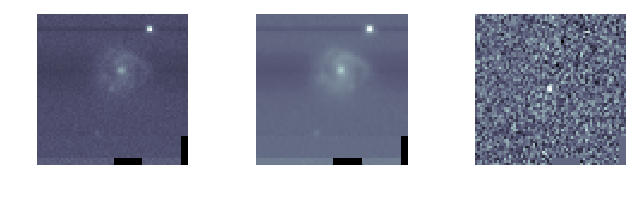

array([[0.9999416]], dtype=float32)

In [6]:
with open('714287740515015072.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al, normalize=True, old_norm=True)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))